In [ ]:
# Libraries
import os
import logging
import json
import glob
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from functools import partial

In [2]:
# Some settings
# keras.mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')
%matplotlib inline

In [3]:
# Constants and initial parameters
IMAGE_SIZE = 300
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32    # 128 for paper, you'll need a very good GPU. 8 for debugging, 64 for RTX 2070, 256 for A100
CROP_SIZE = int(IMAGE_SIZE * 0.75)
RESIZE_SIZE = 224   # Zoobot, as pretrained, expects 224x224 images
CHANNELS = 3 # 1: grayscale, 3: RGB

MODEL_NAME = 'zoobot_for_clumps.keras'

TFRECORDS_PATH = '../Data/tf_records/'
TRAINING_FILENAMES = sorted(str(p) for p in pathlib.Path(TFRECORDS_PATH).glob('GZ2_ClumpScout_train*.tfrecords'))
VALID_FILENAMES = sorted(str(p) for p in pathlib.Path(TFRECORDS_PATH).glob('GZ2_ClumpScout_val*.tfrecords'))
TEST_FILENAMES = sorted(str(p) for p in pathlib.Path(TFRECORDS_PATH).glob('GZ2_ClumpScout_test*.tfrecords'))

In [4]:
def decode_image(image):
    image = tf.image.decode_png(image, channels=CHANNELS) # 1: output to greyscale
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, CHANNELS])
    # image = tf.image.rgb_to_grayscale(image)
    image = (image / 255.0)
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            #'image/source_id': tf.io.FixedLenFeature([], tf.int64),
            'image/label': tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            #'image/source_id': tf.io.FixedLenFeature([], tf.int64),
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image/encoded'])
    #image_id = tf.cast(example['image/source_id'], tf.int64)
    if labeled:
        label = tf.cast(example['image/label'], tf.int32)
        return image, label #, image_id
    return image #, image_id
    
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [5]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_dataset(TEST_FILENAMES, labeled=True)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-16 12:38:24.528428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-16 12:38:24.528877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomRotation(0.1),
        # layers.RandomZoom(0.2),
        layers.RandomCrop(CROP_SIZE, CROP_SIZE, seed=None),
    ]
)

In [7]:
# Zoobot
effnet = keras.applications.EfficientNetB0(include_top=False, weights=None, classes=1)
effnet.trainable = True

inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Resizing(RESIZE_SIZE, RESIZE_SIZE, interpolation='bilinear')(x)
x = effnet(x)
# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
# x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2, name="top_dropout")(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
# outputs = keras.applications.EfficientNetB0(include_top=True, weights=None, classes=1)(x)

model = keras.Model(inputs, outputs)

for layer in model.layers[1].layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# opt = keras.optimizers.Adam(learning_rate=0.0001) # changed from 0.001

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 225, 225, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 225, 225, 3)       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                             

In [ ]:
# checkpoint_path = './checkpoints/cp-{epoch:04d}.ckpt'

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         filepath=checkpoint_path,
#         verbose=1,
#         save_weights_only=True,
#         save_freq='epoch',
#         monitor='val_acc',
#     )
# ]
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=MODEL_NAME,
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=callbacks)

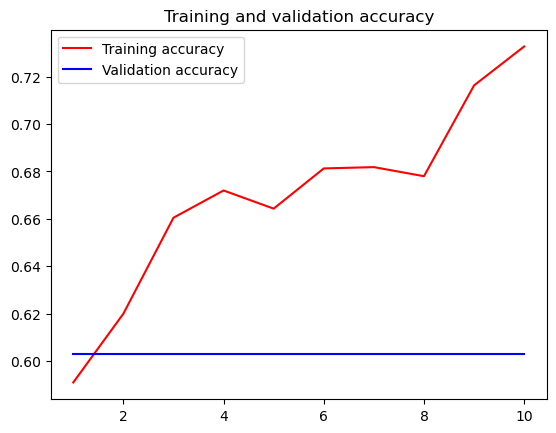

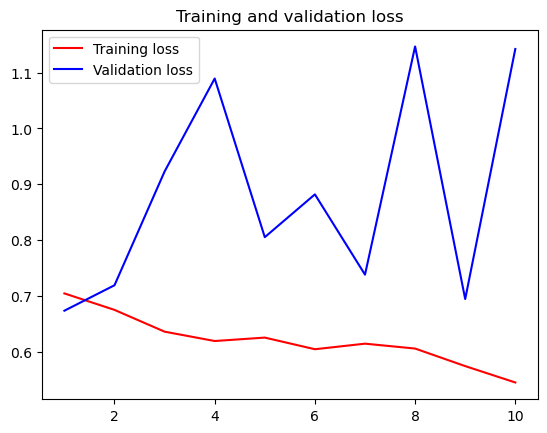

In [10]:
# Plotting results
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
model = keras.models.load_model(MODEL_NAME)
test_loss, test_acc = model.evaluate(valid_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2022-12-16 12:48:57.112770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 6s 241ms/step - loss: 0.6734 - accuracy: 0.6031
Test accuracy: 0.603


2022-12-16 12:49:23.412076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 49ms/step


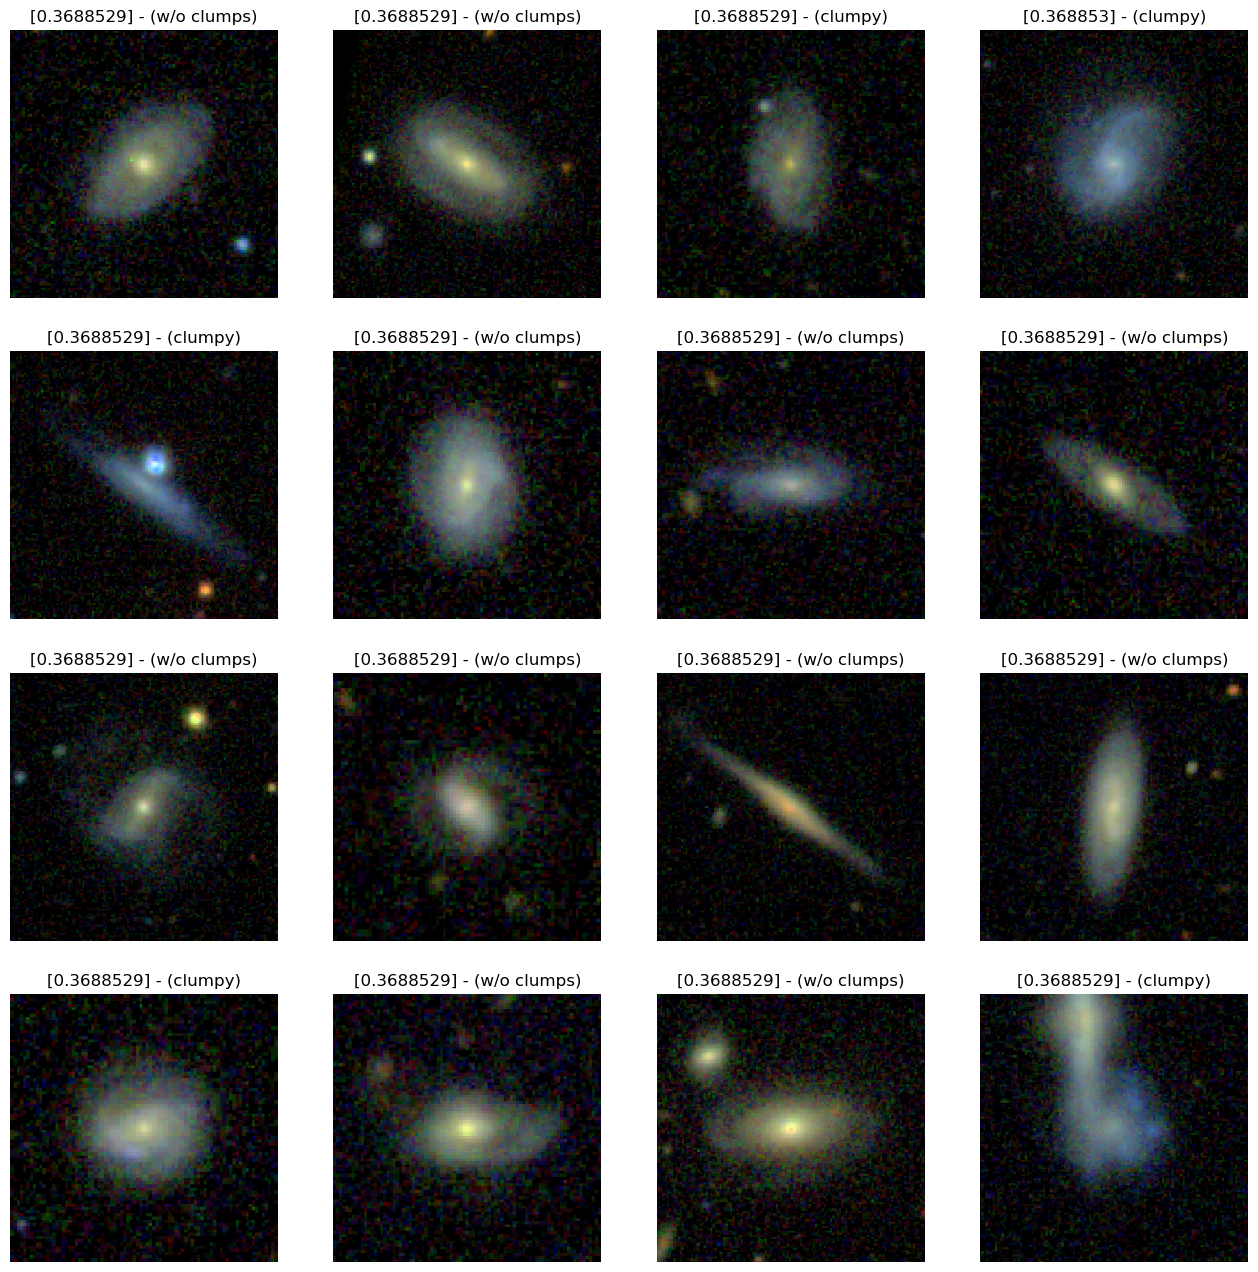

In [13]:
def show_batch_predictions(image_batch, label_batch):
    plt.figure(figsize=(16, 16))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        img_array = tf.expand_dims(image_batch[n], axis=0)
        pred = str(model.predict(img_array)[0])
        if label_batch[n]:
            plt.title(pred + ' - (clumpy)')
        else:
            plt.title(pred + ' - (w/o clumps)')
        plt.axis("off")

image_batch, label_batch = next(iter(test_dataset))
show_batch_predictions(image_batch.numpy(), label_batch.numpy())